In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

matplotlib.rcParams['figure.figsize'] = (24, 18)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams.update({'font.size': 20})

TRAIN_SIZE = 9800
TRAIN_TIME = 6
BATCH_SIZE = 32
BUFFER_SIZE = 500

In [2]:
total_ped_matrix = np.load("../details/total_ped_matrix.npy")

with open("../details/ped_dataset.pkl", 'rb') as f:
    ped_dataset = pickle.load(f)
    
with open("../details/scene_info.pkl", 'rb') as handle:
    scene_info = pickle.load(handle)

In [13]:
nusc = NuScenes(version='v1.0-trainval', 
                dataroot='../../../../../data/', 
                verbose=False)

so_map = NuScenesMap(dataroot='../../../../../data/', 
                       map_name='singapore-onenorth')
bs_map = NuScenesMap(dataroot='../../../../../data/', 
                       map_name='boston-seaport')
sh_map = NuScenesMap(dataroot='../../../../../data/', 
                       map_name='singapore-hollandvillage')
sq_map = NuScenesMap(dataroot='../../../../../data/', 
                       map_name='singapore-queenstown')

# dict mapping map name to map file
map_files = {'singapore-onenorth': so_map,
             'boston-seaport': bs_map,
             'singapore-hollandvillage': sh_map,
             'singapore-queenstown': sq_map}

In [6]:
# # calculating the values for standardization for every feature
# mean_values = np.mean(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))
# std_values = np.std(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))

# # standardization
# total_ped_matrix = (total_ped_matrix - mean_values) / std_values

In [3]:
# train_test split

x_train = total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :]
y_train = total_ped_matrix[:TRAIN_SIZE, TRAIN_TIME:, :2]

x_test = total_ped_matrix[TRAIN_SIZE:, :TRAIN_TIME, :]
y_test = total_ped_matrix[TRAIN_SIZE:, TRAIN_TIME:, :2]

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [6]:
# defining the custom rmse loss function
def rmse_loss(gt_path, pred_path):
    '''
    calculates custom rmse loss between every time point
    '''
#     gt_path = tf.reshape(gt_path, [-1, 10, 2])
#     pred_path = tf.reshape(pred_path, [-1, 10, 2])
    
#     return K.mean(K.sqrt(K.sum(K.square(gt_path-pred_path), axis=1)))    
    return K.sqrt(K.mean(K.square(gt_path-pred_path)))

In [7]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(LSTM(16, input_shape=x_train.shape[-2:]))
lstm_model.add(RepeatVector(10))
lstm_model.add(LSTM(8, return_sequences=True,activation='relu'))
lstm_model.add(TimeDistributed(
                Dense(2, activation='linear')))

lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
                       loss=rmse_loss, metrics=["accuracy"])

In [8]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1536      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 8)             800       
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 2)             18        
Total params: 2,354
Trainable params: 2,354
Non-trainable params: 0
_________________________________________________________________


In [9]:
# checkpoint for saving the best model
filepath="../checkpoints/lstm_best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', 
                                                verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

train_history = lstm_model.fit(train_data, epochs=20,
                         verbose=0, callbacks=callbacks_list,
                         validation_data=val_data,
                         steps_per_epoch=300,
                         validation_steps=60
                         )


Epoch 00001: val_accuracy improved from -inf to 0.93151, saving model to ../checkpoints/lstm_best.hdf5

Epoch 00002: val_accuracy did not improve from 0.93151

Epoch 00003: val_accuracy did not improve from 0.93151

Epoch 00004: val_accuracy improved from 0.93151 to 0.93333, saving model to ../checkpoints/lstm_best.hdf5

Epoch 00005: val_accuracy did not improve from 0.93333

Epoch 00006: val_accuracy improved from 0.93333 to 0.93484, saving model to ../checkpoints/lstm_best.hdf5

Epoch 00007: val_accuracy did not improve from 0.93484

Epoch 00008: val_accuracy improved from 0.93484 to 0.93490, saving model to ../checkpoints/lstm_best.hdf5

Epoch 00009: val_accuracy did not improve from 0.93490

Epoch 00010: val_accuracy improved from 0.93490 to 0.93620, saving model to ../checkpoints/lstm_best.hdf5

Epoch 00011: val_accuracy improved from 0.93620 to 0.93766, saving model to ../checkpoints/lstm_best.hdf5

Epoch 00012: val_accuracy improved from 0.93766 to 0.93896, saving model to ../c

In [10]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

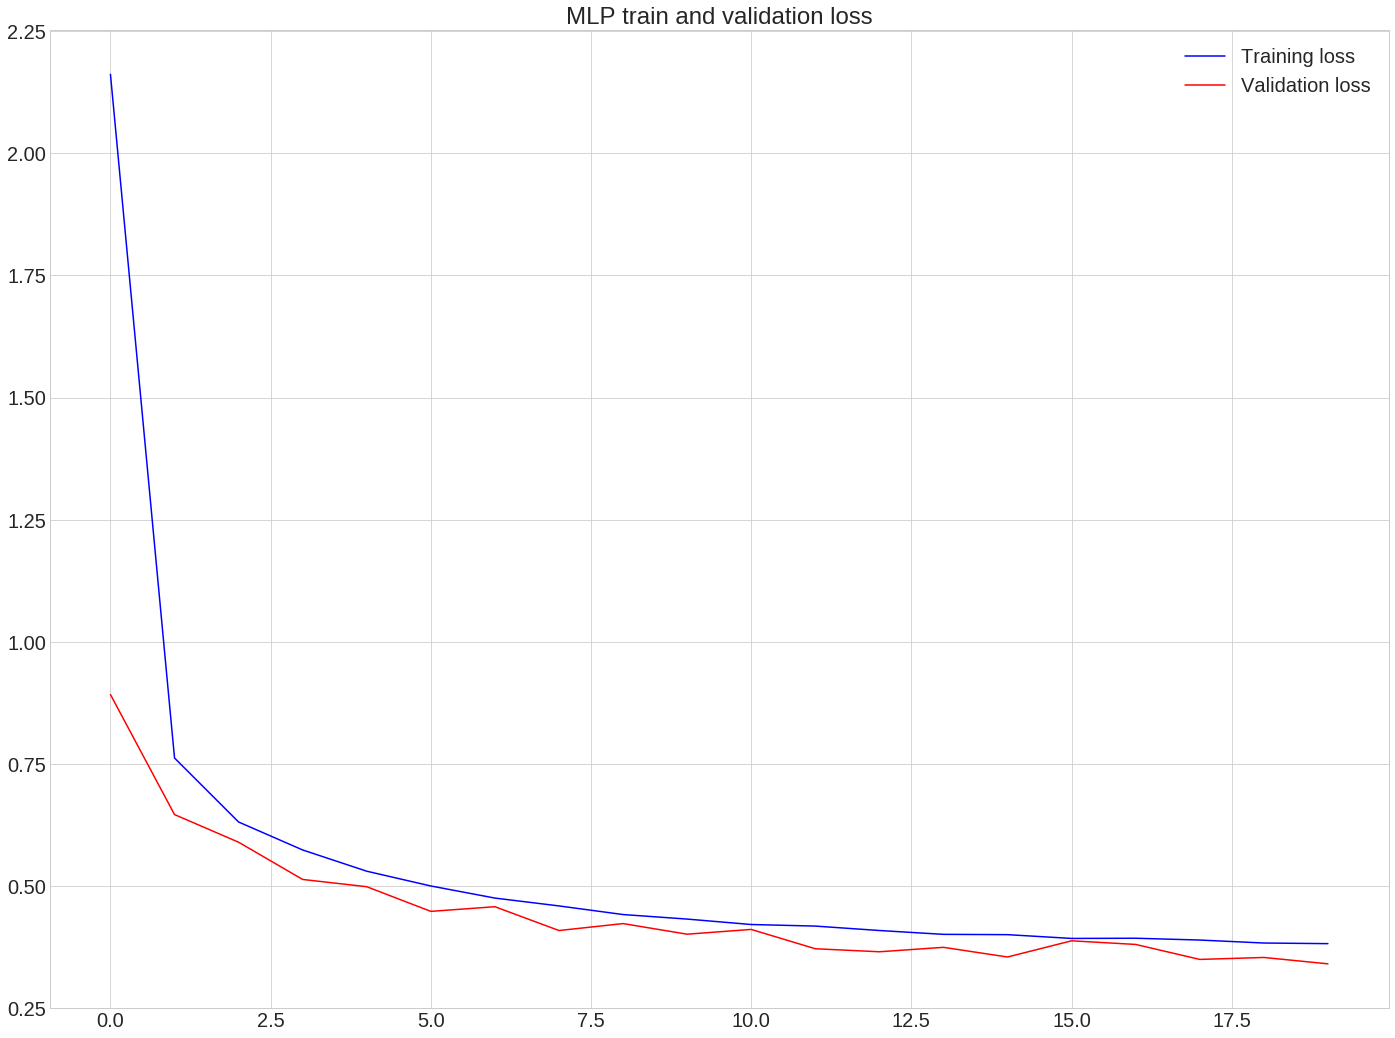

In [11]:
plot_train_history(train_history, "MLP train and validation loss")

In [12]:
# undo normalization for plotting
def move_from_origin(l, origin):
    x0, y0 = origin
    return [[x + x0, y + y0] for x, y in l]

def rotate_from_y(l, angle):
    theta = -angle
    return [(x*np.cos(theta) - y*np.sin(theta), 
                    x*np.sin(theta) + y*np.cos(theta)) for x, y in l]

# loss calculation for test prediction
def rmse_error(l1, l2):
    loss = 0.0
    
    if len(np.array(l1).shape) < 2:
        return ((l1[0] - l2[0])**2 + (l1[1] - l2[1])**2)**0.5
    for p1, p2 in zip(l1, l2):
        loss += ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5
    return (loss / float(len(l1)))

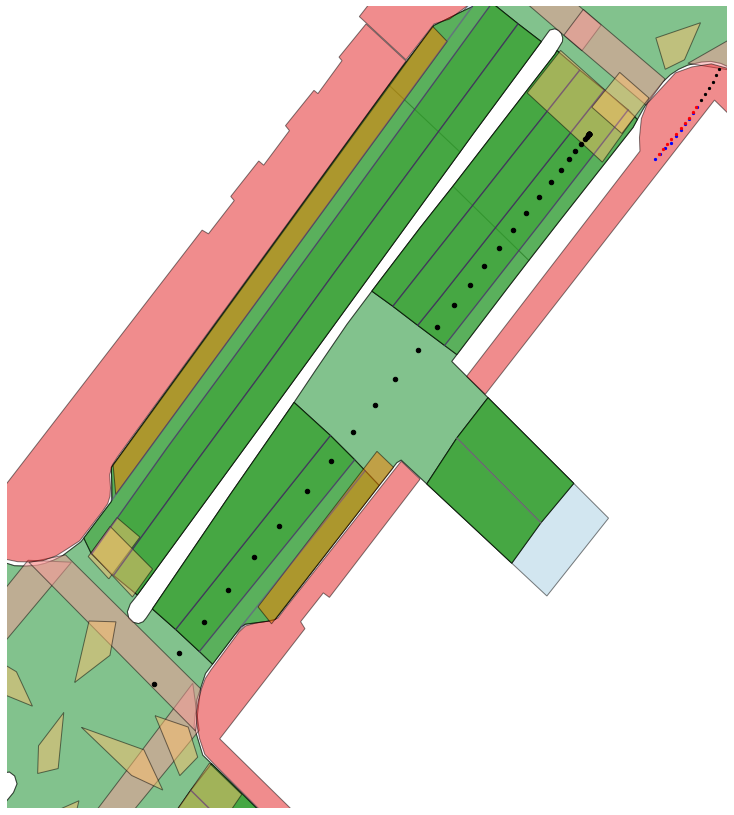

Loss in m is 0.2794514525963981
Loss of final position in m is 0.6274537566256018


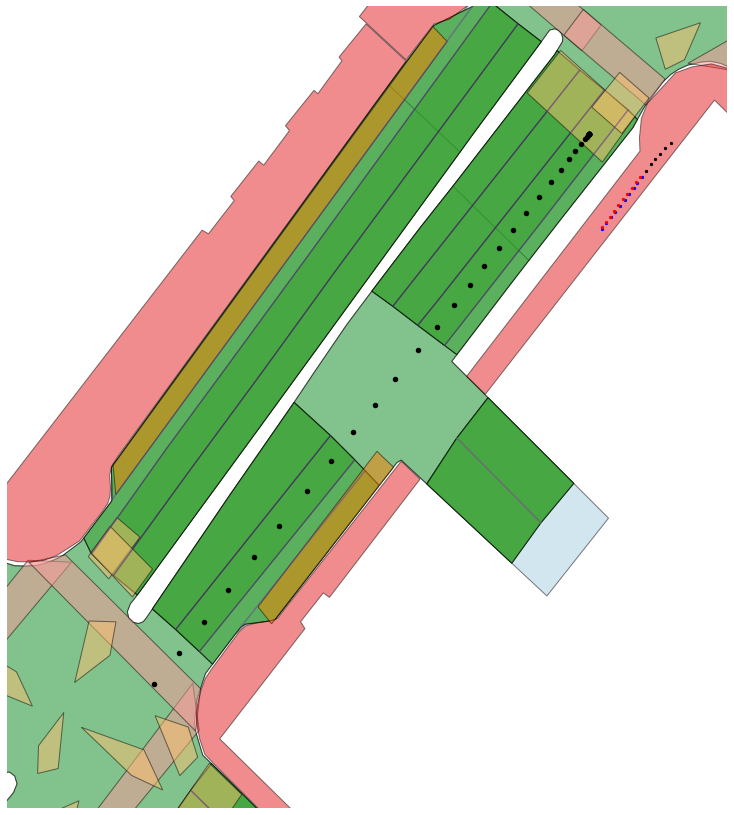

Loss in m is 0.17191038945842477
Loss of final position in m is 0.24358928802859572


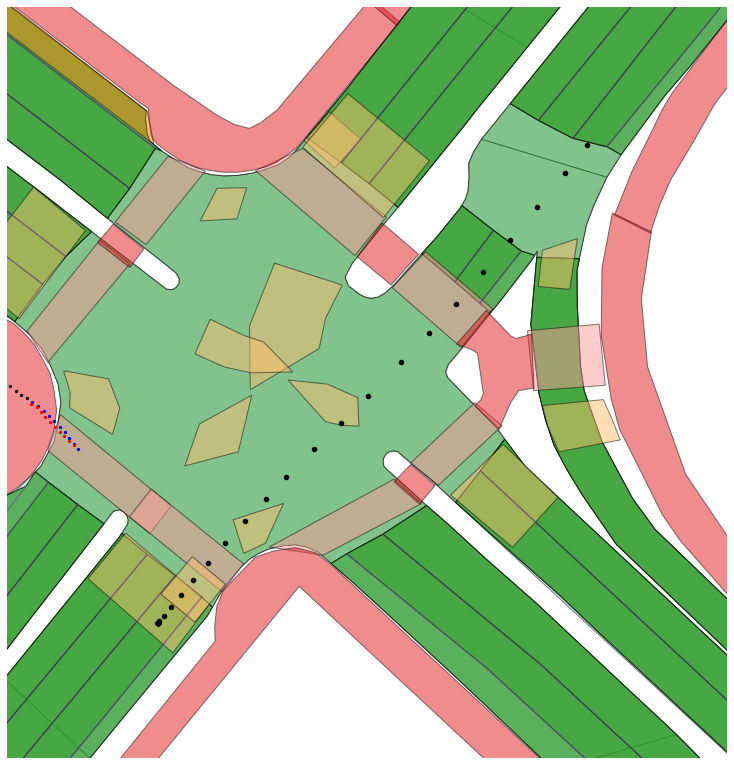

Loss in m is 0.3871336906188444
Loss of final position in m is 0.5467278441133695
0.2794985108912224
0.4725902962558557


In [14]:
ade_values = []
fde_values = []

for test_idx in range(TRAIN_SIZE, TRAIN_SIZE+3):
    test_data = total_ped_matrix[test_idx:test_idx+1,:6,:]
    predictions = lstm_model.predict(test_data).reshape(-1, 2)
    predictions = move_from_origin(rotate_from_y(predictions, ped_dataset[test_idx]["angle"]),
                                   ped_dataset[test_idx]["origin"])

    n_scene = ped_dataset[test_idx]["scene_no"]
    ego_poses = map_files[scene_info[str(n_scene)]["map_name"]].render_egoposes_on_fancy_map(
                    nusc, scene_tokens=[nusc.scene[n_scene]['token']], verbose=False,
                    render_egoposes=True, render_egoposes_range=False, 
                    render_legend=False)

    plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[:6,:2]), c='k', s=5, zorder=2)
    plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[6:,:2]), c='b', s=5, zorder=3)
    plt.scatter(*zip(*predictions), c='r', s=5, zorder=4)
    plt.show()
    
    loss = rmse_error(predictions, 
                      np.array(ped_dataset[test_idx]["translation"])[6:,:2])
    final_loss = rmse_error(predictions[-1], 
                            np.array(ped_dataset[test_idx]["translation"])[-1,:2])

    
    print(f"Loss in m is {loss}")
    print(f"Loss of final position in m is {final_loss}")
    
    ade_values.append(loss)
    fde_values.append(final_loss)
    
print(np.mean(np.array(ade_values)))
print(np.mean(np.array(fde_values)))